In [1]:
%matplotlib inline

import io, os, sys, types, datetime, pickle, warnings, time

warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import numpy as np
from numpy.linalg import eig, inv

import math

from scipy import interpolate, spatial, stats

import seaborn as sns

import skimage.io as skiIo
from skimage import exposure, img_as_float, filters, morphology, transform

from sklearn import linear_model
from sklearn import metrics

In [2]:
""" ============== path settings =============="""

' ============== path settings =============='

In [3]:
module_path = os.path.join(os.path.dirname(os.getcwd()), 'python_cluster', 'functions')

In [4]:
module_path

'/Users/lily/Lily/Academic/AW_Lab/code/NSP_extension/python/python_cluster/functions'

In [5]:
# env = 'Windows'
# if(env == 'Windows'):
#     module_path = 'W:\\2019_09_NSP_Extension\\code\\NSP_codes\\python_cluster\\helper_functions'
# elif(env == 'Mac'):
#     module_path = '/Users/lily/Lily/Academic/AW_Lab/code/python_cluster/helper_functions'

In [6]:
# Mac, Figure_Output1, Data_Output1, Ctrl_22hrs_Gal80_s3r101_annotation.csv, 0, 1, 24, 18, 50, 20, 0.9, FasII

In [7]:
### import custom functions
if module_path not in sys.path:
    sys.path.append(module_path)
import settings as settings
import helper as my_help
import intensity_calculation as my_int
import parse_bundle as my_pb
import plotting as my_plot

Mac, Figure_Output1, Data_Output1, Ctrl_22hrs_Gal80_s3r101_annotation.csv, 0, 1, 24, 18, 50, 20, 0.9, FasII
Mac, Figure_Output1, Data_Output1, Ctrl_22hrs_Gal80_s3r101_annotation.csv, 0, 1, 24, 18, 50, 20, 0.9, FasII


In [8]:
paths = settings.paths
matching_info = settings.matching_info
analysis_params_general = settings.analysis_params_general

In [9]:
matching_info.channel_mapping

{'RFP': 0,
 'GFP': 1,
 'FasII': 2,
 'R3_FasII': 3,
 'R4_FasII': 4,
 0: 'RFP',
 1: 'GFP',
 2: 'FasII',
 3: 'R3_FasII',
 4: 'R4_FasII'}

In [10]:
"""============== main =============="""

'============== main =============='

In [11]:
sns.set_style("dark")

In [12]:
paths.annot_path

'/Users/lily/Lily/Academic/AW_Lab/data/Gal80_data/Annotations/Ctrl/22/Ctrl_22hrs_Gal80_s3r101_annotation.csv'

In [13]:
"""Load data"""
### load summaries
summary_df = pd.read_csv(paths.annot_path)
image_list = summary_df.loc[:,'Image_Name'].unique()
ROI_list = summary_df.loc[:,'ROI_Name'].unique()

In [14]:
image_list, ROI_list

(array(['ctrl80_22hrs_smp3_region1_1.tif'], dtype=object),
 array(['ctrl80_22hrs_smp3_region1_1_ROI_202041_64247.csv'], dtype=object))

In [15]:
i_image = 0

In [16]:
### load other data
image_name = image_list[i_image]
roi_name = ROI_list[i_image]
roi_df = pd.read_csv(os.path.join(paths.roi_path, roi_name))
roi_df.rename(columns = {' ':'No'}, inplace = True)
annot_df = summary_df.groupby(['Image_Name']).get_group(image_list[i_image]).reset_index(drop = True)
m2p_ratio = (summary_df.iloc[0]['imgX_pixel']/summary_df.iloc[0]['imgX_um'], summary_df.iloc[0]['imgY_pixel']/summary_df.iloc[0]['imgY_um'])

In [17]:
""" Process annotation info"""
is_extended_target_list = False
annotation_type = annot_df.loc[0,'Annotation_type']
if(annotation_type == 1):
    bundles_df = my_pb.get_bundles_info_v1(roi_df, annot_df, m2p_ratio[0], m2p_ratio[1], is_extended_target_list)
if(annotation_type == 2):
    bundles_df = my_pb.get_bundles_info_v2(roi_df, annot_df, m2p_ratio[0], m2p_ratio[1], is_extended_target_list)
if(annotation_type == 3):
    bundles_df = my_pb.get_bundles_info_v4(roi_df, annot_df, m2p_ratio[0], m2p_ratio[1], is_print = True)
annot_bundles_df = bundles_df.dropna(axis=0, how='any', inplace = False)
annot_bundles_df.sort_index(inplace = True)

1 7
1: bundle!
2 1
2: T0 of 1!
3 2
3: Target!
4 2
4: Target!
5 2
5: Target!
6 2
6: Target!
7 2
7: Target!
2 1
---annot_df---
1


In [18]:
"""load imaging data"""

'load imaging data'

In [19]:
%time image = img_as_float(skiIo.imread(os.path.join(paths.image_path, image_name)))
image_shape = (image.shape[0], image.shape[1], image.shape[2])
image_info = [image_name, image_shape, m2p_ratio]


CPU times: user 69.8 ms, sys: 99.5 ms, total: 169 ms
Wall time: 176 ms


In [20]:
""" Process images """
### number of channels
nChannels = min(image.shape)# number of channels of original image


In [21]:
matching_info.channels_type

'FasII'

In [22]:
# # if not is_process_channels:
#     num_norm_channels = len(matching_info.channel_mapping_checking.keys()) # number of channels of normalized image
# else:
num_norm_channels = len(matching_info.channel_cmap.keys())
    
if(nChannels == 2):
    print("2 channels!")
    ### normalize channels
    image_norm = np.empty(image_shape + (num_norm_channels,), dtype=image[:,0,:,:].dtype, order='C')
    thr = np.zeros((2))
    
    # RFP_norm
    %time image_norm[:,:,:,0] = exposure.rescale_intensity(image[:,0,:,:], in_range = 'image', out_range='dtype')
    # GFP_norm
    %time image_norm[:,:,:,1] = exposure.rescale_intensity(image[:,1,:,:], in_range = 'image', out_range='dtype')    
    
    del image
        
elif(nChannels == 4):
    print("4 channels!")
    ### normalize channels
    if(matching_info.channels_type == 'checking'):
        image_norm = np.empty(image_shape + (num_norm_channels,), dtype=image[:,:,:,1].dtype, order='C')
        # RFP_norm
        %time image_norm[:,:,:,0] = image[:,:,:,0]
        # GFP_norm
        %time image_norm[:,:,:,1] = image[:,:,:,1]
        # 24b10
        %time image_norm[:,:,:,2] = image[:,:,:,2]
        # FasII
        %time image_norm[:,:,:,3] = image[:,:,:,3]

        del image
    elif(matching_info.channels_type == 'R3R4'):
        thr = np.zeros((2))
        image_norm = np.empty(image_shape + (num_norm_channels,), dtype=image[:,:,:,1].dtype, order='C')
        # RFP_norm
        %time image_norm[:,:,:,0] = exposure.rescale_intensity(image[:,:,:,0], in_range = 'image', out_range='dtype')
        # GFP_norm
        %time image_norm[:,:,:,1] = exposure.rescale_intensity(image[:,:,:,1], in_range = 'image', out_range='dtype')

        %time thr[0] = filters.threshold_isodata(image_norm[:,:,:,1])
        %time thr[1] = filters.threshold_mean(image_norm[:,:,:,1])

        %time gfp = transform.match_histograms(image_norm[:,:,:,1], image_norm[:,:,:,0])

        print("R3/R4 v1")
        r3_img = image_norm[:,:,:,0] - gfp
        r3_img[r3_img<0] = 0
        image_norm[:,:,:,2] = exposure.rescale_intensity(r3_img, in_range = 'image', out_range='dtype')
        r4_img = image_norm[:,:,:,0] * gfp
        image_norm[:,:,:,3] = exposure.rescale_intensity(r4_img, in_range = 'image', out_range='dtype')

        print("R3/R4 v2")
        gfp_thr = morphology.binary_opening((image_norm[:,:,:,1]>thr[0])*1)
        image_norm[:,:,:,4] = exposure.rescale_intensity(image_norm[:,:,:,0] * (1-gfp_thr), in_range = 'image', out_range='dtype')
        image_norm[:,:,:,5] = exposure.rescale_intensity(morphology.closing(image_norm[:,:,:,1]*((image_norm[:,:,:,1]>((thr[0] + thr[1])/2))*1)))

        print("R3 v3")
        my_help.print_to_log("R3 v3")
        r3_img = image_norm[:,:,:,0] - gfp*settings.analysis_params_general.scale_factor
        r3_img[r3_img<0] = 0
        image_norm[:,:,:,6] = exposure.rescale_intensity(r3_img, in_range = 'image', out_range='dtype')

        del image, gfp, r3_img, r4_img

    elif(matching_info.channels_type == 'FasII'):
        image_norm = np.empty(image_shape + (num_norm_channels,), dtype=image[:,:,:,1].dtype, order='C')
        # RFP_norm
        %time image_norm[:,:,:,0] = exposure.rescale_intensity(image[:,:,:,0], in_range = 'image', out_range='dtype')
        # GFP_norm
        %time image_norm[:,:,:,1] = exposure.rescale_intensity(image[:,:,:,1], in_range = 'image', out_range='dtype')
        # FasII norm
        %time image_norm[:,:,:,2] = exposure.rescale_intensity(image[:,:,:,3], in_range = 'image', out_range='dtype')

        %time thr = filters.threshold_otsu(image_norm[:,:,:,2])

        print("FasII intersect")
#         fasii_thr = morphology.binary_opening((image_norm[:,:,:,2]>thr)*1)
#         image_norm[:,:,:,3] = exposure.rescale_intensity(image_norm[:,:,:,0] * fasii_thr, in_range = 'image', out_range='dtype')
#         image_norm[:,:,:,4] = exposure.rescale_intensity(image_norm[:,:,:,1] * fasii_thr, in_range = 'image', out_range='dtype')
        image_norm[:,:,:,3] = image_norm[:,:,:,0]
        image_norm[:,:,:,4] = image_norm[:,:,:,1]
        
        del image

4 channels!
CPU times: user 238 ms, sys: 90.3 ms, total: 328 ms
Wall time: 199 ms
CPU times: user 219 ms, sys: 12.3 ms, total: 232 ms
Wall time: 125 ms
CPU times: user 218 ms, sys: 11.5 ms, total: 230 ms
Wall time: 117 ms
CPU times: user 332 ms, sys: 12.7 ms, total: 345 ms
Wall time: 188 ms
FasII intersect


In [23]:
image_norm.shape

(101, 214, 305, 5)

In [24]:
"""example plot"""

'example plot'

In [25]:
"""Example"""

'Example'

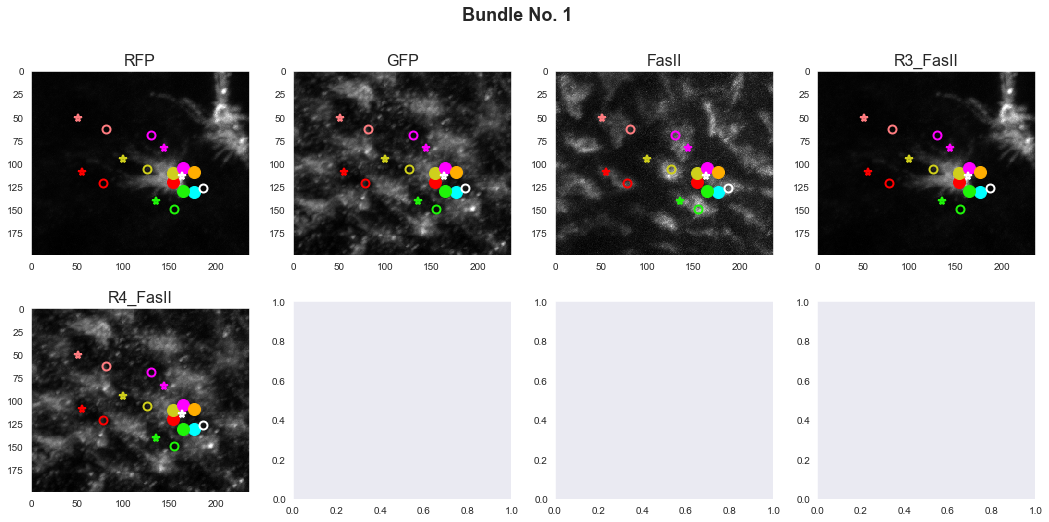

In [26]:
bundle_no = 1
plotSettings = False, False, False, True #isPlotR3Line, isPlotR4Line, isPlotR4s, isLabelOff
my_plot.plot_individual_bundles(bundle_no, bundles_df, image_norm, m2p_ratio[0], m2p_ratio[1], num_subplots = image_norm.shape[-1],
                                is_plot_r3_line = False, is_plot_r4_line = False, is_plot_r4 = False, is_label_off = True)
plt.show()

In [ ]:
"""plot all"""

In [ ]:
for ind, bundle_no in enumerate(annot_bundles_df.index):
    plotSettings = False, False, False, True #isPlotR3Line, isPlotR4Line, isPlotR4s, isLabelOff
    my_plot.plot_individual_bundles(bundle_no, bundles_df, image_norm, m2p_ratio[0], m2p_ratio[1], 
                                    num_subplots = image_norm.shape[-1], is_plot_r3_line = False, is_plot_r4_line = False, is_plot_r4 = False, is_label_off = True)
    plt.show()

In [ ]:
"""visualize slicing"""

In [ ]:
### parameters
analysis_params_general = settings.analysis_params_general
matching_info = settings.matching_info
center_type = settings.analysis_params_general.center_type
slice_type = settings.analysis_params_general.slice_type

### initialization
print('-----' + image_name + '------')
### process
for ind, bundle_no in enumerate(bundles_list):
    ind = list(annot_bundles_df.index).index(bundle_no)
    print("Bundle No: " + str(bundle_no))
    my_help.print_to_log("Bundle No: " + str(bundle_no))

    ### targets info
    ind_targets, coord_targets = my_help.get_target_coords(bundle_no, bundles_df)
    ind_targets, coord_targets_extended = my_help.get_target_coords(bundle_no, bundles_df, return_type = 'extended')
    coord_center = my_help.get_bundle_center(bundle_no, bundles_df)
    coord_r4s = my_help.get_rx_coords(bundle_no, bundles_df, ind_targets, 4)
    coord_r3s = my_help.get_rx_coords(bundle_no, bundles_df, ind_targets, 3)
    coord_rcells = np.concatenate((coord_r4s, coord_r3s))

    ### slice info
    slice_zero_point = coord_targets[matching_info.target_id_to_index[7],:] # T3'
    slice_one_point = coord_targets[matching_info.target_id_to_index[3],:] # T3

    length_one_point = coord_targets[matching_info.target_id_to_index[4],:]

    center_points = [coord_targets[0,:], coord_center[0,:]]

    r_cell_nos = [4,4]

    ### get slicing params and calculate matrix
    bundle_params = [bundle_no, 
                    ind_targets, 
                    coord_targets,
                    coord_targets_extended,
                    coord_center, 
                    slice_zero_point, 
                    slice_one_point, 
                    length_one_point, 
                    center_points[analysis_params_general.center_type],
                    r_cell_nos[analysis_params_general.center_type]]
    phis_1, phi_edges_1, rel_points_1 = my_int.get_slice_params_v1(bundles_df, bundle_params, image_name, is_plot = False, is_checking = True)
    phis_2, phi_edges_2, rel_points_2 = my_int.get_slice_params_v3(bundles_df, bundle_params, image_name, is_plot = False, is_checking = True)
    my_plot.plot_slicing_options(phis_1, phis_2, phi_edges_1, phi_edges_2, bundle_no)

In [ ]:
"""intensity matrix"""

In [ ]:
paths = settings.paths
analysis_params_general = settings.analysis_params_general
matching_info = settings.matching_info
num_norm_channels = image_norm.shape[-1]
img_name = image_info[0]

for ind, bundle_no in enumerate(annot_bundles_df.index):
    print("Bundle No: ", bundle_no)
    my_help.print_to_log("Bundle No: " + str(bundle_no))

    category_id = annot_bundles_df.iloc[0]['CategoryID']
    sample_id = annot_bundles_df.iloc[0]['SampleID']
    region_id = annot_bundles_df.iloc[0]['RegionID']



    ### targets info
    ind_targets, coord_targets = my_help.get_target_coords(bundle_no, bundles_df)
    coord_center = my_help.get_bundle_center(bundle_no, bundles_df)
    coord_r4s = my_help.get_rx_coords(bundle_no, bundles_df, ind_targets, 4)
    coord_r3s = my_help.get_rx_coords(bundle_no, bundles_df, ind_targets, 3)
    coord_rs = np.concatenate((coord_r4s, coord_r3s))

    ### parameters
    pp_i = params[ind]
    rel_points_i = rel_points[ind]

    matrix = my_help.delete_zero_columns(intensity_matrix[ind, :, :, :, :], -100, 3)
    if(len(matrix.flatten()) > 0):
    #         ## heat map
    #         plt.ioff()
    #         ori_x = np.round(np.linspace(0, analysis_params_general.radius_expanse_ratio[analysis_params_general.center_type], matrix.shape[2]), 2)
    #         tick_params = [2, 1, ori_x, 21] ### tickTypeX, tickTypeY, tickArg2_X, tickArg2_Y
    #         for thr_function_ids in [0, 1, 2, 3]: # different thresholding methods
    #             thrs = np.zeros((num_norm_channels))
    #             if(thr_function_ids == 0):
    #                 thrs = np.zeros((num_norm_channels))
    #             elif(thr_function_ids == 1):
    #                 thrs = thr_otsu
    #             elif(thr_function_ids == 2):
    #                 thrs = thr_li
    #             elif(thr_function_ids == 3):
    #                 thrs = thr_isodata

    #             fig_name = f'{category_id}_s{sample_id}r{region_id}_bundle_no_{bundle_no}_{thr_function_ids}.png'
    #             fig_params = [pp_i, img_name, fig_name]
    #             plot_options = [thrs, thr_function_ids, num_norm_channels]
    #             fig = my_plot.plot_bundle_vs_matrix_all(bundle_no, bundles_df, image_norm, matrix, fig_params, tick_params, plot_options, is_label_off = True, is_save = True, is_true_x_tick = True, is_ori_tick = False)
    #             plt.close(fig)

        ## polar plot
        fig_params = [pp_i, img_name]
        # plot_options = [True, True] # isLabelOff, isSave
        for channel_no in range(num_norm_channels):
            fig = my_plot.plot_polar(bundle_no, bundles_df, image_norm, channel_no, matrix, fig_params, rel_points_i, is_label_off = True, is_save = True, is_extended_target = True)
            plt.close(fig)

    else:
        print("error! No intensity matrix calculated!")

In [ ]:
# t0_to_bundle_map = {}
# for ind in annot_df.index:
#     t0_to_bundle_map[annot_df.loc[ind, 'T0']] = annot_df.loc[ind, 'Bundle_No']
    

In [ ]:
# def get_bundles_info_v3(roi_df, annot_df, x_ratio, y_ratio, is_extended_target_list, is_print):
#     ### initialization
#     r_coords_list = []
#     for i in range(6):
#         for j in ['X', 'Y', 'Z']:
#             r_coords_list.append('coord' + '_' + j + '_R' + str(i+1))
#     center_coords_list = []
#     for j in ['X', 'Y', 'Z']:
#         center_coords_list.append('coord_' + j + '_Center')

#     ### get column names
#     qc_col_names = my_help.group_headers(annot_df, 'is_', True)
#     orient_col_names = my_help.group_headers(annot_df, 'Orientation_', True)
#     img_col_names = my_help.group_headers(annot_df, 'ID', True)
#     flag_col_names = my_help.group_headers(annot_df, 'if_', True)
#     bundles_cols = ['Bundle_No', 'num_Rcells'] + r_coords_list + center_coords_list + qc_col_names + orient_col_names + img_col_names + flag_col_names
    
#     ### hell-T0 map
#     t0_to_bundle_map = {}
#     for ind in annot_df.index:
#         t0_to_bundle_map[annot_df.loc[ind, 'T0']] = annot_df.loc[ind, 'Bundle_No']
    
#     ### create new dataframe
#     bundles_df = pd.DataFrame(columns = bundles_cols)

#     ### group ROI.csv according to label -- grouping individual roi together
#     roi_df_group = roi_df.groupby('Label') \
#         .agg({'X':'size', 'No':'mean'}) \
#         .rename(columns={'X':'count','No':'order'})
#     roi_df_group.sort_values('order', inplace=True) #sort according to order of roi added, so that ind of roi_df_group = bundle_no - 1
#     roi_df_group.reset_index(inplace=True)

#     ### update bundle coordinates
#     for ind in roi_df_group.index:
#         bundle_no = ind+1
#         print(bundle_no, roi_df_group.loc[ind, 'count'])

#         ## this ROI is a bundle
#         if(roi_df_group.loc[ind, 'count'] == 7):
#             print(f'{bundle_no}: bundle!')
#             df_tmp = pd.DataFrame(columns = bundles_cols)
#             df_tmp.loc[0,'Bundle_No'] = int(ind+1)
#             df_bd = roi_df.loc[roi_df['Label'] == list(roi_df_group.Label)[ind]]
#             df_tmp.loc[0,'num_Rcells'] = int(df_bd.shape[0])

#             ## R1- R6 coordinates
#             for i in range(6):
#                 df_tmp.loc[0,['coord_X_R' + str(i+1)]] = float(df_bd.loc[df_bd.index[i], 'X'])
#                 df_tmp.loc[0,['coord_Y_R' + str(i+1)]] = float(df_bd.loc[df_bd.index[i], 'Y'])
#                 df_tmp.loc[0,['coord_Z_R' + str(i+1)]] = float(df_bd.loc[df_bd.index[i], 'Slice'])

#             ## center of bundle coordinates
#             df_tmp.loc[0,'coord_X_Center'] = float(df_bd.loc[df_bd.index[6], 'X'])
#             df_tmp.loc[0,'coord_Y_Center'] = float(df_bd.loc[df_bd.index[6], 'Y'])
#             df_tmp.loc[0,'coord_Z_Center'] = float(df_bd.loc[df_bd.index[6], 'Slice'])

#             bundles_df = bundles_df.append(df_tmp, ignore_index=True, sort=True)

#         ## this ROI is a target of an annotated bundle
#         elif(roi_df_group.loc[ind, 'count'] == 1 and ind+1 in t0_to_bundle_map.keys()):
#             print(f'{bundle_no}: T0 of {t0_to_bundle_map[ind+1]}!')
#             df_tmp = pd.DataFrame(columns = bundles_cols)
#             df_tmp.loc[0,'Bundle_No'] = int(ind+1)
#             df_bd = roi_df.loc[roi_df['Label'] == list(roi_df_group.Label)[ind]]
                        
#             ## target coordinates
#             df_tmp.loc[0,'coord_X_T0'] = float(df_bd.loc[df_bd.index[0], 'X'])
#             df_tmp.loc[0,'coord_Y_T0'] = float(df_bd.loc[df_bd.index[0], 'Y'])
#             df_tmp.loc[0,'coord_Z_T0'] = float(df_bd.loc[df_bd.index[0], 'Slice'])
# #             print(df_tmp.loc[0,'coord_X_T0'])

#             bundles_df = bundles_df.append(df_tmp, ignore_index=True, sort=True)
        
#         ## this ROI is a target on its own
#         elif(roi_df_group.loc[ind, 'count'] == 2):
#             print(f'{bundle_no}: Target!')
#             df_tmp = pd.DataFrame(columns = bundles_cols)
#             df_tmp.loc[0,'Bundle_No'] = int(ind+1)
#             df_bd = roi_df.loc[roi_df['Label'] == list(roi_df_group.Label)[ind]]
                        
#             ## target coordinates
#             df_tmp.loc[0,'coord_X_T0'] = float(df_bd.loc[df_bd.index[0], 'X'])
#             df_tmp.loc[0,'coord_Y_T0'] = float(df_bd.loc[df_bd.index[0], 'Y'])
#             df_tmp.loc[0,'coord_Z_T0'] = float(df_bd.loc[df_bd.index[0], 'Slice'])
            
#             ### center coordinates
#             df_tmp.loc[0,'coord_X_Center'] = float(df_bd.loc[df_bd.index[1], 'X'])
#             df_tmp.loc[0,'coord_Y_Center'] = float(df_bd.loc[df_bd.index[1], 'Y'])
#             df_tmp.loc[0,'coord_Z_Center'] = float(df_bd.loc[df_bd.index[1], 'Slice'])
            
#             bundles_df = bundles_df.append(df_tmp, ignore_index=True, sort=True)

#         else:
#             print(f'ERROR! Bundle No. {ind+1} count incorrect!')
    
#     bundles_df = bundles_df.set_index('Bundle_No')
    
#     ### get center for target Ts:
#     for ind in t0_to_bundle_map.keys():
#         print(ind, t0_to_bundle_map[ind])
#         bundles_df.loc[ind,'coord_X_Center'] = bundles_df.loc[t0_to_bundle_map[ind],'coord_X_Center']
#         bundles_df.loc[ind,'coord_Y_Center'] = bundles_df.loc[t0_to_bundle_map[ind],'coord_Y_Center']
#         bundles_df.loc[ind,'coord_Z_Center'] = bundles_df.loc[t0_to_bundle_map[ind],'coord_Z_Center']

#     ## update target & quality-control info
#     print("---annot_df---")
#     my_help.print_to_log("---annot_df---")

#     for ind in annot_df.index:

#         bundle_no = annot_df.iloc[ind]['Bundle_No'].astype(int)
#         print(bundle_no)
#         my_help.print_to_log(str(bundle_no))

#         ### target info
#         if(is_extended_target_list):
#             bundles_df.loc[bundle_no, 'TargetNo_T3'] = annot_df.loc[ind,'T3'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T4'] = annot_df.loc[ind,'T4'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T5'] = annot_df.loc[ind,'T5'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T2'] = annot_df.loc[ind,'T2'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T1'] = annot_df.loc[ind,'T1'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T6'] = annot_df.loc[ind,'T6'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T20'] = annot_df.loc[ind,'T20'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T50'] = annot_df.loc[ind,'T50'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T40'] = annot_df.loc[ind,'T40'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T30'] = annot_df.loc[ind,'T30'].astype(int)
#         else:
#             bundles_df.loc[bundle_no, 'TargetNo_T3'] = annot_df.loc[ind,'T3'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T4'] = annot_df.loc[ind,'T4'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T5'] = annot_df.loc[ind,'T5'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T2'] = annot_df.loc[ind,'T2'].astype(int)
#             bundles_df.loc[bundle_no, 'TargetNo_T7'] = annot_df.loc[ind,'T7'].astype(int)

#         ### T0 coordinates
#         ind_t0 = annot_df.loc[ind,'T0'].astype(int)
#         bundles_df.loc[bundle_no, 'coord_X_T0'] = bundles_df.loc[ind_t0, 'coord_X_T0']
#         bundles_df.loc[bundle_no, 'coord_Y_T0'] = bundles_df.loc[ind_t0, 'coord_Y_T0']
#         bundles_df.loc[bundle_no, 'coord_Z_T0'] = bundles_df.loc[ind_t0, 'coord_Z_T0']

#         ### quality control and flag info
#         bundles_df.loc[bundle_no, orient_col_names] = annot_df.loc[ind, orient_col_names]    
#         bundles_df.loc[bundle_no, qc_col_names] = annot_df.loc[ind, qc_col_names].astype(int)
#         bundles_df.loc[bundle_no, flag_col_names] = annot_df.loc[ind, flag_col_names].astype(int)

#         ### category, sample and region info.
#         bundles_df.loc[bundle_no, img_col_names] = annot_df.loc[ind, img_col_names] 

#     ### X,Y coordinates from microns to pixels
#     x_coord_cols = my_help.group_headers(bundles_df, 'coord_X', True)
#     bundles_df.loc[:,x_coord_cols] = bundles_df.loc[:,x_coord_cols] * x_ratio
#     y_coord_cols = my_help.group_headers(bundles_df, 'coord_Y', True)
#     bundles_df.loc[:,y_coord_cols] = bundles_df.loc[:,y_coord_cols] * y_ratio
    
#     return bundles_df

In [ ]:
# def get_target_coords(bundle_no, bundles_df, **kwarg):
#     ### unravel params
#     if('return_type' in kwarg.keys()):
#         return_type = kwarg['return_type']
#     else:
#         return_type = 'target'
#     if('dim' in kwarg.keys()):
#         dim = kwarg['dim']
#     else:
#         dim = 2
#     index_to_target_id = matching_info.index_to_target_id
    
#     if(return_type == 'target'):
#         if(dim == 2):
#             coord_cols_list = ['coord_X_T0', 'coord_Y_T0']
#         elif(dim == 3):
#             coord_cols_list = ['coord_X_T0', 'coord_Y_T0', 'coord_Z_T0']
#     elif(return_type == 'extended'):
#         if(dim == 2):
#             coord_cols_list = ['coord_X_Center', 'coord_Y_Center']
#         elif(dim == 3):
#             coord_cols_list = ['coord_X_Center', 'coord_Y_Center', 'coord_Z_Center']
    
#     target_inds = []
#     target_coords = np.zeros((len(index_to_target_id), dim))
    
#     if('TargetNo_T0' not in bundles_df.columns):
#         target_inds.append(bundle_no)
#     else:
#         target_inds.append(bundles_df.loc[bundle_no,'TargetNo_T'])
#     target_coords[0,:] = bundles_df.loc[bundle_no, coord_cols_list].to_numpy()

#     for i in range(1,len(target_coords)):
#         target_inds.append(int(bundles_df.loc[bundle_no,'TargetNo_T' + str(index_to_target_id[i])]))
#         target_coords[i,:] = bundles_df.loc[target_inds[i], coord_cols_list].to_numpy()

#     return target_inds, target_coords